In [971]:
import numpy as np
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt
import time

import theano_time_corex
import linearcorex

from sklearn.datasets import make_spd_matrix

import random
from scipy.stats import multivariate_normal

# Generate Data

In [1021]:
""" Generates random covariance matrix with `nb` independent blocks
"""
def generate_covariance(n, nb=2):
    sizes=[]
    for i in range(n%nb):
        sizes.append(n//nb+1)
    for i in range(nb-n%nb):
        sizes.append(n//nb)
    assert sum(sizes) == n
    pref = 0
    ret = np.zeros((n, n))
    for s in sizes:
        """
        A = np.zeros((s, s))
        for i in range(s):
            A[i, :i+1] = np.random.uniform(-1, 1, size=(i+1,))
            A[i][i] = np.random.uniform(0.1, 1)
        ret[pref:pref+s, pref:pref+s] = np.dot(A, A.T)
        """
        ret[pref:pref+s, pref:pref+s] = make_spd_matrix(s)
        pref += s
    return ret

`nt` - number of timesteps  
`nv` - number of variables (`p` in the paper)  
`nb` - number of block in the covariance matrix  

For each timestep we generate `ns` samples. For the half of timesteps we use one covariance matrix and for the second half we use another sigma (`sigma1`, `sigma2`).  

`X` - the training set
`Y` - the testing set on which we report negative log-likelihood for our estimate of covariance

In [1105]:
nt = 10
nv = 100
nb = 16
myu = np.zeros((nv,))
sigma1 = generate_covariance(nv,nb)
sigma2 = generate_covariance(nv,nb)

order = range(nv)
random.shuffle(order)
tmp = np.zeros(sigma2.shape)
for i in range(nv):
    for j in range(nv):
        tmp[i][j] = sigma2[order[i], order[j]]
sigma2 = tmp

gt = [sigma1] * (nt // 2)
gt += [sigma2] * (nt // 2)

X = []
for i in range(nt):  
    ns = 5
    X.append(np.random.multivariate_normal(myu, gt[i], size=(ns,)))
    
Y = []
for i in range(nt):  
    ns = 30
    Y.append(np.random.multivariate_normal(myu, gt[i], size=(ns,)))

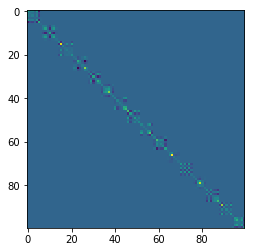

In [1106]:
plt.imshow(sigma1)
plt.show()

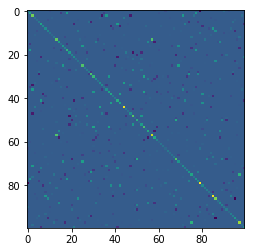

In [1107]:
plt.imshow(sigma2)
plt.show()

### This graph shows how well the covariance at timestep t models the test data at timestep t+1. Clearly we should see a peak at the middle timestep.

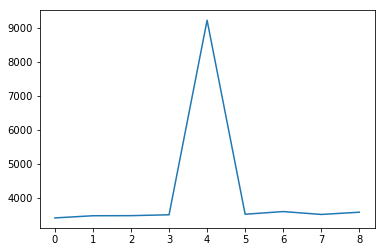

NLL = 37288.987437


In [1108]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=gt[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

### Negative log-likelihood of ground truth on each timestep. We report the sum of negative log-likelihood over timesteps.

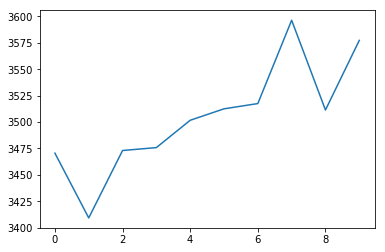

NLL = 35045.4375618


In [1109]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=gt[t]) for sx in x]) for x,t in zip(Y, range(nt))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

# Learn independent linear corexes on each timestep

In [1110]:
cs = []
for x in X:
    c = linearcorex.Corex(n_hidden=8*2,
                    max_iter=300,
                    anneal=True)
    c.fit(x)
    cs.append(c)
    
print sum([c.tc for c in cs])

1551.8923378


In [1111]:
covs = [c.get_covariance() for c in cs]

### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. We would like to see a peak at the middle timestep, but as we don't have many training samples there is no clear peak. We can say that the model overfits a lot at each timestep.

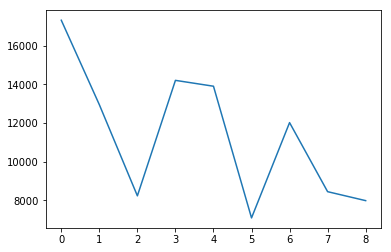

NLL = 102152.109348


In [1112]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

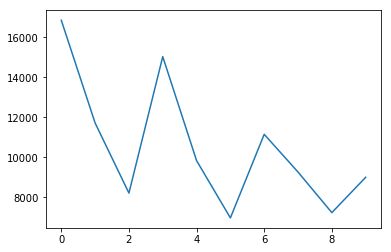

NLL = 105237.224075


In [1113]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

# no regularization

In [ ]:
c0 = theano_time_corex.TimeCorexW(nt=nt,
                                nv=nv,
                                n_hidden=8*2,
                                max_iter=500,
                                verbose=True,
                                anneal=True)
c0.fit(X)
print sum(c0.tc)

In [ ]:
covs = c0.get_covariance()

In [ ]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

In [ ]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

# reg on W

In [ ]:
cw = theano_time_corex.TimeCorexW(nt=nt,
                                nv=nv,
                                n_hidden=8*2,
                                max_iter=400,
                                verbose=True,
                                anneal=True,
                                l1=3)
cw.fit(X)
print sum(cw.tc)

In [ ]:
covs = cw.get_covariance()

In [ ]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

In [ ]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

# reg on MI

In [ ]:
cmi = theano_time_corex.TimeCorexGlobalMI(nt=nt,
                                        nv=nv,
                                        n_hidden=8*2,
                                        max_iter=400,
                                        verbose=True,
                                        anneal=True,
                                        l1=0.01)
cmi.fit(X)
print sum(cmi.tc)

In [ ]:
covs = cmi.get_covariance()

In [ ]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

In [ ]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

# L1 regularization on the difference of neighbouring covariance estimates

In [1124]:
csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                        nv=nv,
                                        n_hidden=8*2,
                                        max_iter=400,
                                        verbose=False,
                                        anneal=True,
                                        l1=10)
csig.fit(X)
print sum(csig.tc)

Annealing iteration finished, time = 3.38928508759
Annealing iteration finished, time = 3.37427902222
Annealing iteration finished, time = 3.37533283234
Annealing iteration finished, time = 3.38465094566
Annealing iteration finished, time = 3.41221904755
Annealing iteration finished, time = 3.38173699379
Annealing iteration finished, time = 3.38336396217
1112.09521791


In [1125]:
covs = csig.get_covariance()

### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. As we regularize the model we have less overfitting and the system is able to find the change at the middle.

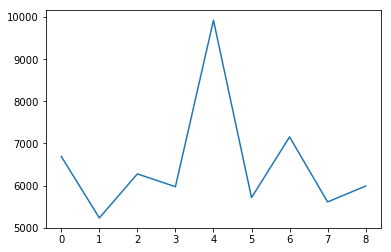

NLL = 58578.3943613


In [1126]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

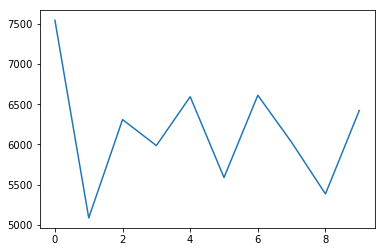

NLL = 61546.7910722


In [1127]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

# Summary of the results

1) Negative log-likelihood results:

| Model | NLL |  
|-------|-----|  
| ground truth        |  35045.43 |  
| independent corexes | 105237.22 |  
| regularized corex   |  61546.79 |  


2) Without regularization the system doesn't detect the global change at the middle timestep, but with regularization it finds.